In [1]:
import pandas as pd
import ast
import numpy as np
import scipy.stats 
from scipy.stats import spearmanr
from cyvcf2 import VCF
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from tqdm import tqdm

In [2]:
####### Read assembly alleles #######
df_all = pd.DataFrame(columns = [0,1,2,3,4,5])
for n in [x for x in range(1,23)]:
    df = pd.read_csv(f"assembly_alleles_chr{n}.csv", sep = "\t", header=None)
    df[4] = df[4].apply(ast.literal_eval)
    df[5] = df[5].apply(ast.literal_eval)
    df = df[df[4].apply(lambda x: len(x) != 0)]
    df = df[df[5].apply(lambda x: len(x) == 0)]
    df_all = pd.concat([df_all, df], ignore_index=True)
df_all

,0,1,2,3,4,5
0,chr1,264724,264970,chr1_264724_264970_TGACCCTGACTT,[GGTGGGTCCTGAGGAGAACAAAGCTCTGGTTCTAATCCTAACCCT...,[]
1,chr1,266830,267045,chr1_266830_267045_AACCTGCTGCTTCCTGGAGGAAGACAG...,[AGACCAGCTGCCCCACGAAGGAACCAGAGCCAACCTGCTGCTTCC...,[]
2,chr1,595477,595647,chr1_595477_595647_TCCCGGCAGTGCAGGCCCCTCTCTAGA...,[TAGAGCCGAGACGCTCCCAGCTGTGTAGGCTTCCCAGCAGTGCAG...,[]
3,chr1,596153,597020,chr1_596153_597020_CACACTCATACACACCCAGATCATATA...,[CAGTGCACCTGCACAAACACACCCACACATGCACCCATATCATAT...,[]
4,chr1,597021,597135,chr1_597021_597135_TACACACTCA,[CTCAAATCATACGCACACTAGTGTATACATGTACACACTCACACA...,[]
...,...,...,...,...,...,...
816702,chr22,50787891,50788000,chr22_50787891_50788000_AGAT,[GACCCAAGCTCTTGATAGCGAAAGGCAGAAAAGATAGATGGTAAA...,[]
816703,chr22,50788151,50788224,chr22_50788151_50788224_TTG,[TTTGTTTGTTGTTTGCTTTTCTGTGGGGTTTTTGTTGTTGTTGTT...,[]
816704,chr22,50790941,50791181,chr22_50790941_50791181_AGGGTC,[AAGAGTAGAGATAGATTGTAAAGATAATAATAGGGTTAGGCATAG...,[]
816705,chr22,50796685,50796788,chr22_50796685_50796788_AC,[TGCTGGAGCAAGCTAGGACAAGTGATTTGGAACACACACACACAC...,[]


In [3]:
####### Read LongTR output on HG002 #######
calls = []

for i in range(1,22):
    vcf = VCF(f"../HG002_wg_hipstr_adotto_dec14_chr{i}.vcf.gz")
    for variant in vcf:
        if variant.CHROM == "chrX" or variant.CHROM == "chrY":
            break
        calls.append([variant.CHROM, variant.POS, variant.INFO['START'], 
                      variant.INFO['END'], variant.INFO['PERIOD'],
                      variant.REF, variant.ID, variant.gt_bases[0].split("|"), variant.format('GB')[0]])
LongTR_data = pd.DataFrame(calls, 
    columns=["chrom","pos_LongTR", "start_LongTR",
             "end_LongTR", 'period', "ref_LongTR", "ID",
             "gbs_LongTR", 'gb_LongTR'])


####### Read TRGT output on HG002 #######
calls = []
vcf = VCF("../HG002_wg_trgt_hg38.sorted.vcf.gz")
for variant in vcf:
    if variant.CHROM == "chrX" or variant.CHROM == "chrY":
        break
    AL = variant.format("AL")[0]
    GB = [A - len(variant.REF) for A in AL]
    calls.append([variant.CHROM, variant.POS, variant.REF, 
                  variant.INFO['TRID'], variant.gt_bases[0].split("/"), GB])
TRGT_data = pd.DataFrame(calls, 
    columns=["chrom","pos_TRGT", "ref_TRGT", "ID", "gbs_TRGT", 'gb_TRGT'])


In [4]:
###### Fix alleles and merge data #######

def fix_seq(pos_hipstr, start_hipstr, ref_hipstr, seq_hipstr, 
            end_hipstr, assembly_seq): 
    
    # Fix cases where LongTR expanded the coordinates 
    # because of a nearby SNP
    
    if np.isnan(pos_hipstr):
        return np.nan
    diff_pos = int(start_hipstr - pos_hipstr)
    end_hipstr_new = pos_hipstr + len(ref_hipstr) - 1
    diff_end = int(end_hipstr_new - end_hipstr)
    assert(diff_pos >= 0 and diff_end >= 0) # becase only HipSTR might change the pos
    if diff_pos > 0:
        seq_hipstr = [s[diff_pos:] for s in seq_hipstr]
    if diff_end > 0: 
        seq_hipstr = [s[0:len(s) - diff_end] for s in seq_hipstr]
    seq_hipstr = [s[1:] for s in seq_hipstr] # 0 based
    seq_assembly = sorted([s[1:] for s in assembly_seq]) # 0 based
    alleles_hipstr = sorted(seq_hipstr)
    return alleles_hipstr, seq_assembly

both = pd.merge(TRGT_data, LongTR_data, on = ['chrom', 'ID'])
both['len'] = both['end_LongTR'] - both['start_LongTR']
both_assembly = pd.merge(both, df_all, left_on = 'ID', right_on=3)

both_assembly[['gbs_LongTR_corrected', 'assembly']] = both_assembly.apply(lambda row: fix_seq(row['pos_LongTR'], 
                                                              row['start_LongTR'], row['ref_LongTR'],
                                                              row['gbs_LongTR'], row['end_LongTR'], row[4]), 
                                                              axis = 1, result_type='expand')
both_assembly['gbs_TRGT'] = both_assembly['gbs_TRGT'].apply(lambda x: sorted(x))

both_assembly['assembly_gb'] = both_assembly.apply(lambda row: [len(x) - row['len'] for x in row['assembly']], axis = 1)



In [8]:
both_assembly[['ID', 'assembly_gb']].to_csv("assembly_gb.csv", index=False)

In [5]:
def concordance(GT_first, GT_assembly):
    length_concordance = 0
    length_concordance_1 = 0
    seq_concordance = 0
    if len(GT_first) < 2 or len(GT_assembly) < 2: # no genotype from both haplotypes
        return np.nan
    GT_assembly = list(set(GT_assembly)) ## sometimes there are two alleles from same haplotype
    if len(GT_assembly) > 2:
        return np.nan
    if len(GT_assembly) == 1:
        GT_assembly = [GT_assembly[0], GT_assembly[0]]
    if (len(GT_first) != 2 or len(GT_assembly) != 2):
        print(ID)# Both have call
    GT_first.sort()
    GT_assembly.sort()
    seq_concordance = (GT_first == GT_assembly)
    GT_assembly = sorted([len(x) for x in GT_assembly])
    GT_first = sorted([len(x) for x in GT_first])
    if abs(GT_first[0] - GT_assembly[0]) < 2 and abs(GT_first[1] - GT_assembly[1]) < 2:
        length_concordance_1 = 1
    if abs(GT_first[0] - GT_assembly[0]) < 1 and abs(GT_first[1] - GT_assembly[1]) < 1:
        length_concordance = 1    
    return length_concordance, length_concordance_1, seq_concordance

tqdm.pandas()
both_assembly[['len_conc_TRGT',
              'len_conc_1_TRGT', 'seq_conc_TRGT']] = both_assembly.progress_apply(lambda row: concordance(row['gbs_TRGT'],
                                                                                  row['assembly']), 
                                                                         axis = 1, result_type='expand')


both_assembly[['len_conc_LongTR',
              'len_conc_1_LongTR', 'seq_conc_LongTR']] = both_assembly.progress_apply(lambda row: concordance(row['gbs_LongTR_corrected'],
                                                                                  row['assembly']), 
                                                                         axis = 1, result_type='expand')




/cm/shared/apps/spack/cpu/opt/spack/linux-centos8-zen/gcc-8.3.1/anaconda3-2020.11-da3i7hmt6bdqbmuzq6pyt7kbm47wyrjp/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 800895/800895 [00:46<00:00, 17102.60it/s]


In [53]:
#### overlap with good regions ####

SV_regions = pd.read_csv("GRCh38_HG002-T2TQ100-V1.0_stvar.benchmark.bed", sep = "\t", header=None)
SV_regions.columns = ['chrom', 'start', 'end']

def find_overlap(ID):
    chrom, start, end, motif = ID.split("_")
    start = int(start)
    end = int(end)
    SV_regions_local = SV_regions[SV_regions['chrom'] == chrom]
    found = 0
    for index, row in SV_regions_local.iterrows():
        #print(row['start'], row['end'], start, end)
        if start >= int(row['start']) and end <= int(row['end']):
            found = 1
            break
    return found

both_assembly['SV_regions'] = both_assembly.progress_apply(lambda row: find_overlap(row['ID']), axis = 1)

100%|██████████| 799806/799806 [09:33<00:00, 1393.42it/s]


In [64]:
both_assembly = both_assembly.dropna()
longer = both_assembly[(both_assembly['len'] > 500) & (both_assembly['SV_regions'] == 1)]
print(len(longer))
print(len(longer[longer['len_conc_TRGT'] == 1]) / len(longer))
print(len(longer[longer['len_conc_LongTR'] == 1]) / len(longer))

20911
0.7503706183348476
0.8309023958682034


In [43]:
longer[(longer['len_conc_1_LongTR'] != 1) & 
       (longer['len_conc_1_TRGT'] == 1) &
        (longer['chrom'] == 'chr1')][['ID','gb_TRGT', 'gb_LongTR', 'assembly_gb']]



,ID,gb_TRGT,gb_LongTR,assembly_gb
228,chr1_1192331_1192896_TATGAGTGTAGACACTCCAGTTGG,"[0, 0]",0|-9,"[0, 0]"
251,chr1_1248062_1249717_CTCCCACTCCGCCCTACAGGCCGGG...,"[397, 593]",396|593,"[396, 594]"
308,chr1_1349948_1351488_GGGGGGAGTGAGGAGGGGGCCTGGA...,"[-1080, -1080]",-1080|-1082,"[-1080, -1080]"
320,chr1_1366802_1367713_TGAGTGTGAATTGGTGACTGTGTGA...,"[11, 11]",-21|11,"[11, 11]"
620,chr1_1931127_1932447_AAAAAATTCTTAAAAAAATTGGCTG...,"[-9, 1]",1|-10,"[-8, 1]"
790,chr1_2326956_2327597_ACACAGAG,"[5, 5]",3|5,"[5, 5]"
1734,chr1_5386801_5387816_TG,"[5180, 5195]",5178|5193,"[5181, 5195]"
2285,chr1_6744207_6744856_TTTTTTTTTTTTTTTTTTTTTGAGA...,"[-6, -2]",0|0,"[-1, -5]"
2635,chr1_7743793_7744452_TCTTTTCTTTTCTTTTTTTTTTCTG...,"[0, -3]",0|-1,"[0, -3]"
3780,chr1_9810003_9810853_GCTCACGCCTCTAATCCCAGAACTT...,"[139, 160]",139|139,"[139, 160]"


In [64]:
inside_SV_regions = both_assembly[both_assembly['SV_regions'] == 1]
print(len(inside_SV_regions[inside_SV_regions['len_conc_1_TRGT'] == 1]) / len(inside_SV_regions))
print(len(inside_SV_regions[inside_SV_regions['len_conc_1_LongTR'] == 1]) / len(inside_SV_regions))

SV_regions_ID = list(inside_SV_regions['ID'])

0.9888941791173795
0.9929336573331485


[0.8491215996733683, 0.8182399813877741, 0.8450765864332604] [0.8626074283136502, 0.7492573824917002, 0.7260964912280702]


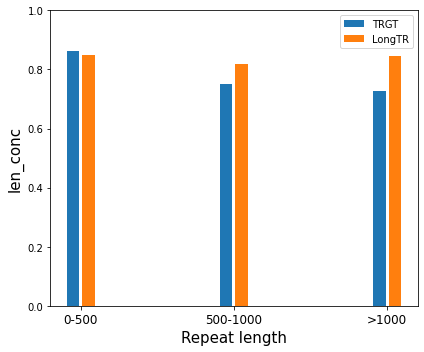

In [36]:
fig = plt.figure()
fig.set_size_inches((6, 5))
ax = fig.add_subplot(111)

val = 'len_conc'

yvals_trgt = []
yvals_longtr = []

sep = 500
sep2 = 1000

xx = both_assembly[both_assembly['len'] < sep]
yvals_trgt.append(len(xx[xx[f'{val}_TRGT']  == 1])/len(xx[~xx[f'{val}_TRGT'].isna()]))
yvals_longtr.append(len(xx[xx[f'{val}_LongTR']  == 1])/len(xx[~xx[f'{val}_LongTR'].isna()]))

xx = both_assembly[(both_assembly['len'] >= sep) & (both_assembly['len'] < sep2)]
yvals_trgt.append(len(xx[xx[f'{val}_TRGT']  == 1])/len(xx[~xx[f'{val}_TRGT'].isna()]))
yvals_longtr.append(len(xx[xx[f'{val}_LongTR']  == 1])/len(xx[~xx[f'{val}_LongTR'].isna()]))

xx = both_assembly[both_assembly['len'] >= sep2]
yvals_trgt.append(len(xx[xx[f'{val}_TRGT']  == 1])/len(xx[~xx[f'{val}_TRGT'].isna()]))
yvals_longtr.append(len(xx[xx[f'{val}_LongTR']  == 1])/len(xx[~xx[f'{val}_LongTR'].isna()]))

print(yvals_longtr, yvals_trgt)
ax.bar([0,10,20], yvals_trgt, label="TRGT")
ax.bar([1,11,21], yvals_longtr, label="LongTR")
ax.set_ylim(0,1)
ax.set_xlabel("Repeat length", size=15)
ax.set_ylabel(f"{val}", size=15)
ax.set_xticks([0.5, 10.5,20.5]) 
ax.set_xticklabels([f"0-{sep}", f"{sep}-{sep2}", f">{sep2}"], fontsize=12)
ax.legend()
fig.tight_layout()
# fig.savefig("Sequence_concordance.pdf", dpi=1200)

0 250 750868 0.8472474522818925 0.862263407150125
250 500 27209 0.9016869418207211 0.8721011430041531
500 750 12983 0.8130632365400909 0.7414311022105831
750 1000 4186 0.8349259436215958 0.7735308170090779
1000 1250 1796 0.8680400890868597 0.7778396436525612
1250 1500 939 0.8519701810436635 0.739084132055378
1500 1750 528 0.8465909090909091 0.7367424242424242
1750 2000 324 0.8734567901234568 0.7623456790123457
2000 2250 216 0.8472222222222222 0.75
2250 2500 127 0.8818897637795275 0.7559055118110236
2500 2750 92 0.7934782608695652 0.6304347826086957
2750 3000 88 0.8068181818181818 0.5681818181818182
3000 3250 63 0.7619047619047619 0.6507936507936508
3250 3500 45 0.8 0.6666666666666666
3500 3750 49 0.6938775510204082 0.5306122448979592
3750 3750 293 0.7064846416382252 0.4129692832764505


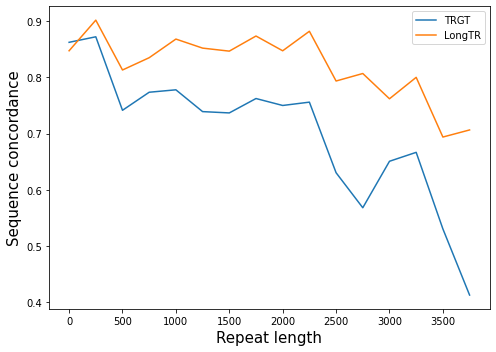

In [52]:
fig = plt.figure()
fig.set_size_inches((7, 5))
ax = fig.add_subplot(111)

MINLEN = 0
MAXLEN = 4000

val = 'len_conc'
lenbins = range(MINLEN, MAXLEN+1,250)
xvals = []
yvals_trgt = []
yvals_longtr = []
for j in range(len(lenbins)-1):
    lb = lenbins[j]
    if lb < MAXLEN - 250:
        ub = lenbins[j+1]
        xx = both_assembly[(both_assembly['len']>=lb) & (both_assembly['len']<ub)]
    if lb >= MAXLEN - 250:
        xx = both_assembly[(both_assembly['len']>=lb)]
    if len(xx) > 10:
        xvals.append(lb)
        yvals_trgt.append(len(xx[xx[f'{val}_TRGT']  == 1])/len(xx[~xx[f'{val}_TRGT'].isna()]))
        yvals_longtr.append(len(xx[xx[f'{val}_LongTR']  == 1])/len(xx[~xx[f'{val}_LongTR'].isna()]))
        print(lb, ub, len(xx), yvals_longtr[-1], yvals_trgt[-1])
ax.plot(xvals, yvals_trgt, label="TRGT")
ax.plot(xvals, yvals_longtr, label="LongTR")
ax.set_xlabel("Repeat length", size=15)
ax.set_ylabel(f"Sequence concordance", size=15)
ax.legend()
fig.tight_layout()
fig.savefig("Sequence_concordance.pdf", dpi=1200)


In [29]:
def compare_all(GT_LongTR, GT_assembly, GT_TRGT):
    if len(GT_LongTR) < 2 or len(GT_assembly) < 2 or len(GT_TRGT) < 2: # no genotype from both haplotypes
        return np.nan
    GT_assembly = list(set(GT_assembly)) ## sometimes there are two alleles from same haplotype
    if len(GT_assembly) > 2:
        return np.nan
    if len(GT_assembly) == 1:
        GT_assembly = [GT_assembly[0], GT_assembly[0]]
    GT_assembly = [len(x) for x in GT_assembly]
    GT_LongTR = [len(x) for x in GT_LongTR]
    GT_TRGT = [len(x) for x in GT_TRGT]
    
    GT_LongTR.sort()
    GT_TRGT.sort()
    GT_assembly.sort()
    if GT_TRGT == GT_assembly or GT_LongTR == GT_assembly:
        return False
    if GT_TRGT == GT_LongTR and (abs(GT_TRGT[0] - GT_assembly[0]) > 10 or abs(GT_TRGT[1] - GT_assembly[1]) > 10):
        return True


# both_assembly['compare_all'] = both_assembly.progress_apply(lambda row: compare_all(row['gbs_LongTR_corrected'],
#                                                                                  row['assembly'], row['gbs_TRGT']), 
#                                                                         axis = 1)

# both_assembly[both_assembly['compare_all'] == True][['ID',
#                                                      'gb_TRGT', 
#                                                      'gb_LongTR', 
#                                                      'assembly_gb']].to_csv("not_matching_assembly.csv",
#                                                                             sep = "\t", index=False)

both_assembly[(both_assembly['compare_all'] == True)][['ID','gb_TRGT', 'gb_LongTR', 'assembly_gb']]


,ID,gb_TRGT,gb_LongTR,assembly_gb
1,chr1_266830_267045_AACCTGCTGCTTCCTGGAGGAAGACAG...,"[0, 0]",0|0,"[-59, -59]"
5,chr1_597764_598764_CACGGTGTGGAAACTGCGACACTCACG...,"[97, 705]",97|705,"[1363, 705]"
80,chr1_880249_880321_TGTTTTTTGTGGGT,"[-18, 0]",-18|0,"[0, 0]"
675,chr1_2019243_2019333_GAGCGGCGGGCGGGGCCGGGCTCGG,"[230, 230]",230|230,"[0, 0]"
794,chr1_2325050_2325356_TCTCCTCTC,"[923, 923]",923|923,"[3475, 3469]"
...,...,...,...,...
814220,chr21_43405223_43405310_TA,"[-2, -2]",-2|-2,"[20, -2]"
814247,chr21_43535633_43535826_AAAAT,"[0, 0]",0|0,"[0, -30]"
814536,chr21_44225495_44225784_GGGAAGGCAGTGGGGACAGTGGAGA,"[0, 0]",0|0,"[0, 52]"
814537,chr21_44229566_44229782_CGGTGCCTGGACCCACCCTGGA...,"[0, 0]",0|0,"[129, 0]"


In [14]:
diff_TRGT = both_assembly[both_assembly['seq_conc_TRGT'] == 0]

with open("diff_seq_TRGT.txt", 'w') as f:
    for index,row in diff_TRGT.iterrows():
        f.write(f"{row['ID']}\t0\t{row['gbs_TRGT'][0]}\t{row['assembly'][0]}\n")
        f.write(f"{row['ID']}\t0\t{row['gbs_TRGT'][1]}\t{row['assembly'][1]}\n")
        f.write(f"{row['ID']}\t1\t{row['gbs_TRGT'][0]}\t{row['assembly'][1]}\n")
        f.write(f"{row['ID']}\t1\t{row['gbs_TRGT'][1]}\t{row['assembly'][0]}\n")
f.close()

diff_LongTR = both_assembly[both_assembly['seq_conc_LongTR'] == 0]

with open("diff_seq_LongTR.txt", 'w') as f:
    for index,row in diff_LongTR.iterrows():
        f.write(f"{row['ID']}\t0\t{row['gbs_LongTR_corrected'][0]}\t{row['assembly'][0]}\n")
        f.write(f"{row['ID']}\t0\t{row['gbs_LongTR_corrected'][1]}\t{row['assembly'][1]}\n")
        f.write(f"{row['ID']}\t1\t{row['gbs_LongTR_corrected'][0]}\t{row['assembly'][1]}\n")
        f.write(f"{row['ID']}\t1\t{row['gbs_LongTR_corrected'][1]}\t{row['assembly'][0]}\n")
f.close()


#qsub edit_distance.sh -v tool=TRGT
#qsub edit_distance.sh -v tool=LongTR

/bin/bash: qsub: command not found
/bin/bash: qsub: command not found


In [30]:
edit_distance_TRGT = pd.read_csv("edit_distance_TRGT.txt", sep = "\t", header=None)
edit_distance_LongTR = pd.read_csv("edit_distance_LongTR.txt", sep = "\t", header=None)
edit_distance_LongTR.columns = ['ID', 'pair', 'ed_LongTR']
edit_distance_TRGT.columns = ['ID','pair', 'ed_TRGT']
edit_distance_TRGT = edit_distance_TRGT.groupby(['ID','pair'], as_index=False).mean()
edit_distance_LongTR = edit_distance_LongTR.groupby(['ID', 'pair'], as_index=False).mean()

edit_distance_TRGT = edit_distance_TRGT.groupby(['ID'], as_index=False).agg({'ed_TRGT': 'min'})
edit_distance_LongTR = edit_distance_LongTR.groupby(['ID'], as_index=False).agg({'ed_LongTR': 'min'})

both_assembly_ed = pd.merge(both_assembly, edit_distance_TRGT, on = "ID",
                           how='outer')
both_assembly_ed = pd.merge(both_assembly_ed, edit_distance_LongTR, on = "ID",
                           how='outer')

both_assembly_ed['ed_TRGT'] = both_assembly_ed['ed_TRGT'].fillna(both_assembly_ed['seq_conc_TRGT'])
both_assembly_ed['ed_TRGT'] = both_assembly_ed['ed_TRGT'].replace(True, 0)
both_assembly_ed['ed_normalized_TRGT'] = both_assembly_ed['ed_TRGT'] / both_assembly_ed['len']

both_assembly_ed['ed_LongTR'] = both_assembly_ed['ed_LongTR'].fillna(both_assembly_ed['seq_conc_LongTR'])
both_assembly_ed['ed_LongTR'] = both_assembly_ed['ed_LongTR'].replace(True, 0)
both_assembly_ed['ed_normalized_LongTR'] = both_assembly_ed['ed_LongTR'] / both_assembly_ed['len']


both_assembly_ed


,chrom,pos_TRGT,ref_TRGT,ID,gbs_TRGT,gb_TRGT,pos_LongTR,start_LongTR,end_LongTR,period,...,seq_conc_TRGT,len_conc_LongTR,len_conc_1_LongTR,seq_conc_LongTR,assembly_gb,compare_all,ed_TRGT,ed_LongTR,ed_normalized_TRGT,ed_normalized_LongTR
0,chr1,264725,GTGGGTCCTGAGGAGAACAAAGCTCTGGTTCTAATTCTAACCCTAA...,chr1_264724_264970_TGACCCTGACTT,[GTGGGACCTGAGGAGAACAAAGCTCTGGTTCTAATTCTAACCCTA...,"[0, 0]",264724,264724,264970,12,...,False,1.0,1.0,False,"[0, 0]",False,7.5,6.5,0.030488,0.026423
1,chr1,266831,GACCAGCTGCCCCACGAAGGAACCAGAGCCAACCTGCTGCTTCCTG...,chr1_266830_267045_AACCTGCTGCTTCCTGGAGGAAGACAG...,[GACCAGCTGCCCCACGAAGGAACCAGAGCCAACCTGCTGCTTCCT...,"[0, 0]",266830,266830,267045,59,...,False,0.0,0.0,False,"[-59, -59]",True,60.5,60.0,0.281395,0.279070
2,chr1,595478,AGAGCCGAGACGCTCCCAGCTGTGTAGGCTTCCCAGCAGTGCAGAC...,chr1_595477_595647_TCCCGGCAGTGCAGGCCCCTCTCTAGA...,[AGAGCCGAGACGCTCCCAGCTGTGTAGGCTTCCCAGCAGTGCAGA...,"[0, 0]",595477,595477,595647,37,...,True,1.0,1.0,True,"[0, 0]",False,0.0,0.0,0.000000,0.000000
3,chr1,596154,AGTGCACCTGCACAAACACACCCACACATGCACCCATATCATATAC...,chr1_596153_597020_CACACTCATACACACCCAGATCATATA...,[AGTGCACCTGCACAAACACACCCACACATGCACCCATATCATATA...,"[0, 0]",596153,596153,597020,53,...,True,0.0,0.0,False,"[0, 0]",False,0.0,5.0,0.000000,0.005767
4,chr1,597022,TCAAATCATACGCACACTAGTGTATACATGTACACACTCACACACA...,chr1_597021_597135_TACACACTCA,[TCAAATCATACGCACACTAGTGTATACATGTACACACTCACACAC...,"[0, 0]",597021,597021,597135,10,...,True,0.0,0.0,False,"[0, 0]",False,0.0,3.5,0.000000,0.030702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814314,chr21,46676367,ATTTGTAAAAAATGTTCTGTTCTGCTTCTGTTTTTTTTTTTTTCTT...,chr21_46676366_46676447_TTCTTTTTTTTTTTT,[ATTTGTAAAAAATGTTCTGTTCTGCTTCTGTTTTTTTTTTTTCTT...,"[0, -1]",46676366,46676366,46676447,15,...,True,1.0,1.0,True,"[-1, 0]",False,0.0,0.0,0.000000,0.000000
814315,chr21,46682680,GTTATTTCTTCTCACCTCCATTGGCAAAAAAAAAAAAAAAAAAAAA...,chr21_46682679_46682775_A,[ATGTTATTTCTTCTCACCTCCATTGGCAAAAAAAAAAAAAAAAAA...,"[-12, 2]",46682679,46682679,46682775,1,...,False,0.0,0.0,False,"[-11, 3]",None,0.0,0.0,0.000000,0.000000
814316,chr21,46683065,AGAGTAGAGATAGATTGTAAAGATAATAATAGGGTTAGGCATAGGA...,chr21_46683064_46683304_AGGGTC,[AGAGTAGAGATAGATTGTAAAGATAATAATAGGGTTAGGCATAGG...,"[0, 0]",46683064,46683064,46683304,6,...,True,1.0,1.0,True,"[0, 0]",False,0.0,0.0,0.000000,0.000000
814317,chr21,46688802,GCTGGAGCAAGCTAGGACAAGTGATTTGGAACACACACACACACAC...,chr21_46688801_46688894_AC,[GCTGGAGCAAGCTAGGACAAGTGATTTGGAACACACACACACACA...,"[-8, 6]",46688801,46688801,46688894,2,...,False,0.0,0.0,False,"[0, -8]",None,3.0,3.0,0.032258,0.032258


0 250 684964 0.2718756022214306 0.1893150588936061
250 500 25209 0.5451029394263953 0.36572255940338766
500 750 11105 1.290229626294462 1.3032417829806393
750 1000 3660 1.8715846994535519 1.0790983606557376
1000 1250 1589 2.4704216488357456 2.076777847702958
1250 1500 817 3.2600979192166464 0.9394124847001224
1500 1750 451 2.1197339246119733 0.5931263858093127
1750 2000 280 2.6625 1.292857142857143
2000 2250 187 35.5 33.8903743315508
2250 2500 108 2.611111111111111 0.13425925925925927
2500 2750 73 4.178082191780822 0.4315068493150685
2750 3000 59 30.89830508474576 0.847457627118644
3000 3250 49 103.04081632653062 113.57142857142857
3250 3500 38 3.723684210526316 0.23684210526315788
3500 3750 29 1.9310344827586208 0.15517241379310345
3750 4000 24 1.6458333333333333 0.3541666666666667
4000 4250 28 30.035714285714285 1.0892857142857142
4250 4500 22 160.3181818181818 159.9090909090909


,gb_LongTR,gb_TRGT,assembly_gb,ID,ed_TRGT,ed_LongTR
99757,-2250|-2648,"[-2648, -2250]","[-2250, -2648]",chr2_234645348_234649674_CACTGCCTCCCTACTCC,0.0,0.0
702888,0|0,"[0, 0]","[0, 0]",chr17_22721882_22726238_TGCAAAGGGATATTTGTGAGCG...,0.5,0.0
676057,0|0,"[0, 0]","[0, 0]",chr16_35781840_35786225_TCTAGTTTTTATCAAGGATATT...,0.0,0.0
660213,1397|-574,"[-574, 1397]","[1397, -574]",chr15_100554262_100558689_GATGAGGGACGGGCGGATGA...,0.0,0.0
562533,-4|-4,"[1, 4]","[-4, -4]",chr12_107853022_107857490_TTTGAAAACTGCTCTTAGTT...,22.0,0.0
553640,-2|0,"[-2, 3]","[0, -2]",chr12_79472830_79477187_TGTTCCTAATATCCAGGGGGGA...,4.0,0.0
540303,0|0,"[0, 0]","[0, 0]",chr12_34470178_34474542_ATTTGTTTTTCACATTGGCCTC...,0.0,0.0
487249,-3464|-2550,"[-3464, -2550]","[-2550, -3464]",chr10_133476893_133481179_TCCCAGAGAGTCTCAGCAGG...,0.0,0.0
763811,0|0,"[0, 0]","[0, 0]",chr19_21970213_21974485_TAAGGATTGAGAACCAATTAAA...,0.0,0.0
486938,0|0,"[0, 2]","[0, 0]",chr10_132717466_132721871_CCTGGGTTCTGTCTGGGCGC...,0.0,0.0


4750 4750 107 18.299065420560748 7.785046728971962


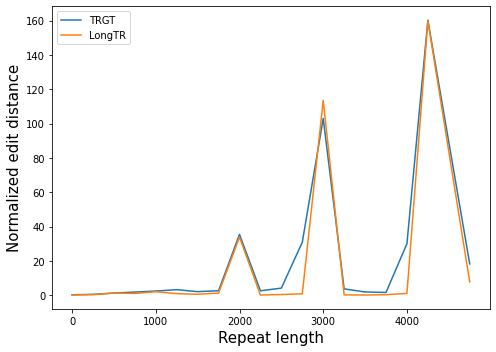

In [76]:
fig = plt.figure()
fig.set_size_inches((7, 5))
ax = fig.add_subplot(111)

MINLEN = 0
MAXLEN = 5000
STEP = 250

val = 'ed'
lenbins = range(MINLEN, MAXLEN+1,STEP)
xvals = []
yvals_trgt = []
yvals_longtr = []
for j in range(len(lenbins)-1):
    lb = lenbins[j]
    if lb < MAXLEN - STEP:
        ub = lenbins[j+1]
        xx = both_assembly_ed[(both_assembly_ed['len']>=lb) & (both_assembly_ed['len']<ub)]
    if lb >= MAXLEN - STEP:
        xx = both_assembly_ed[(both_assembly_ed['len']>=lb)]
    xx = xx.dropna(subset=[f'{val}_TRGT', f'{val}_LongTR'])
    xx = xx[xx['ID'].isin(SV_regions_ID)]
    if len(xx) > 10:
        xvals.append(lb)
        yvals_trgt.append(np.mean(xx[f'{val}_TRGT']))
        yvals_longtr.append(np.mean(xx[f'{val}_LongTR']))
        print(lb, ub, len(xx), yvals_trgt[-1], yvals_longtr[-1])
        if lb == 4250:
            df = xx
            display(df[['gb_LongTR', 'gb_TRGT','assembly_gb','ID', 
                                                    f'{val}_TRGT', 
                        f'{val}_LongTR']].sort_values(f"{val}_LongTR"))
ax.plot(xvals, yvals_trgt, label="TRGT")
ax.plot(xvals, yvals_longtr, label="LongTR")
ax.set_xlabel("Repeat length", size=15)
ax.set_ylabel(f"Normalized edit distance", size=15)
ax.legend()
fig.tight_layout()

In [75]:
both_assembly_ed[(~both_assembly_ed['ID'].isin(SV_regions_ID)) &
                 (both_assembly_ed['ed_normalized_LongTR'] > 10)][['ID','gb_TRGT', 'gb_LongTR', 'assembly_gb']]

,ID,gb_TRGT,gb_LongTR,assembly_gb
114088,chr3_38584519_38584675_AGTAAATAATG,"[0, 6117]",0|0,"[0, 6115]"
182195,chr4_131735173_131735264_CCAGAAGGAAGAAAC,"[0, 0]",0|-15,"[0, 2488]"
265658,chr6_31329639_31329699_T,"[786, 786]",788|786,"[2, 0]"
267536,chr6_35792068_35792156_AAAT,"[8, 8]",8|0,"[0, 12238]"
317484,chr7_27764983_27765058_T,"[1670, 1673]",0|1673,"[0, 0]"
325969,chr7_56370364_56375211_GGCCGGTGTGAGGCAAGGGGCTC...,"[-3841, -2493]",53|108,"[110103, 201862]"
359643,chr7_158595067_158595372_TGGTGGTGA,"[8063, 8086]",8063|8063,"[8092, 19725]"
381477,chr8_69160389_69160456_A,"[912, 912]",911|912,"[0, 0]"
418098,chr9_65838490_65839190_CACACATCACAAACAACTTTCTC...,"[0, 0]",0|-1,"[20923, 20923]"
441104,chr9_133071139_133071724_GGCCCCCCCCGTGCCGCCCAC...,"[-99, -66]",-33|-99,"[20327, -33]"
